In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# going to the repository of this note book
%cd drive/My Drive/Thesis/CPNN_PiggyBack
!ls

/content/drive/My Drive/Thesis/CPNN_PiggyBack
data		     iris-model.pickle	performance	   requirements.txt  Untitled0.ipynb
datasets	     lab		push_to_git.ipynb  results
iris-model-full.pth  models		README.md	   run_test


In [3]:
# IMPORT
import torch
import os
# this module is for training and functions related to data preparation
from models.training import *
from models.cpnn import *
# this is for importing pretrain models.
from models.pretrain import *

#from models.cpnn_others import cPNNExp
#from models.cpnn_seq import cPNNSeq
#from models.cgru_double import cGRULinearDouble
#from models.clstm import *

import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
import argparse
from torch.autograd import Variable
import pprint
import copy


In [4]:
# EDITABLE PARAMETERS
dataset = "sine_rw10_mode5_extended_6-6_1234"

# OTHER PARAMETERS
batch_size = 128
hidden_size = 50
seq_len = 10
# TODO
iterations = 1
loss_on_seq = False
freeze_inputs_weights = False
pretraining_samples = 0
pretraining_epochs = 0
write_weights = False
combination = False
model_type='GRU'
if model_type == "GRU":
    model_class = GRU_Model
else:
    model_class = LSTM_Model

path = os.path.join(
    "performance/pretrain_GRU"
)

In [5]:
df = pd.read_csv("datasets/datasets/sine_rw10_mode5_extended_6-6_1234.csv")
df_task = df[df["task"] == 1]
df_task = df_task.drop(columns="task")

In [6]:
Model = model_class(input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
          )
instance = cPNN(seq_len=seq_len)

In [7]:
if len(df_task) % batch_size == 0:
  n_batches = int(len(df_task) / batch_size)
else:
  n_batches = int(len(df_task) / batch_size) + 1
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
out_h = None
for j in range(0,5):
  for i in range(0, len(df_task), batch_size):
    x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
    y = list(df_task.iloc[i : i + batch_size, -1])
    if len(y) >= seq_len:
      x = np.array(x)
      y = list(y)
      x, y, _ = instance._load_batch(x, y)
      y_pred = Model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      loss = loss_fn(y_pred, y)
      # backward pass
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()


In [ ]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(Model.state_dict())

OrderedDict([   (   'gru.weight_ih_l0',
                    tensor([[-1.0646, -0.5114],
        [-0.3748, -0.2745],
        [ 0.9363,  0.4935],
        [-0.6167, -0.6726],
        [-1.7827, -0.7076],
        [-0.7806, -0.8862],
        [-1.1246, -0.8216],
        [-0.9595, -0.9613],
        [-1.3106, -0.2168],
        [-0.1666, -0.6756],
        [-0.5746, -1.2564],
        [-0.3997, -0.4646],
        [ 0.1099, -0.7011],
        [-1.3598, -0.4100],
        [-2.3198,  0.4367],
        [-0.5158, -0.1717],
        [-0.7476, -0.7001],
        [ 0.2907,  0.1810],
        [-0.9259, -0.3176],
        [-1.3422, -0.9223],
        [-0.1083, -0.1225],
        [-0.5684, -0.6916],
        [-0.5246, -0.4849],
        [-0.5147, -0.4805],
        [-0.7132,  0.7313],
        [-0.9913, -0.5530],
        [ 0.0045, -0.0460],
        [-0.8345, -0.4271],
        [-1.5715, -0.6312],
        [-1.5486, -0.7335],
        [-1.2113, -0.2738],
        [-1.6185, -0.3948],
        [-1.3173, -1.0987],
        [-0.9327

In [ ]:
# Save model
with open("performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_4.pickle", "wb") as fp:
    pickle.dump(Model.state_dict(), fp)

## trying to read the weights of the pretrain model

In [ ]:
pretrain_model = PretrainModel(input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
          )
with open("performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_4.pickle", "rb") as fp:
    pretrain_model.load_state_dict(pickle.load(fp),strict=False)

In [ ]:
import statistics

In [ ]:
df = pd.read_csv("datasets/datasets/sine_rw10_mode5_extended_16-16_1234.csv")
for task in range(1, df["task"].max() + 1):
  acc=[]
  df_task = df[df["task"] == task]
  df_task = df_task.drop(columns="task")
  for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if len(y) >= seq_len:
        x = np.array(x)
        y = list(y)
        x, y, _ = instance._load_batch(x, y)
        y_pred = pretrain_model(x)
        y_pred = get_samples_outputs(y_pred)
        pred, _ = get_pred_from_outputs(y_pred)
        acc.append(accuracy_score(np.array(y),np.array(pred)))
  print(statistics.mean(acc))


0.35121882992327363
0.20711317135549873
0.6440776854219948
0.8104859335038364


In [ ]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(pretrain_model.state_dict())

OrderedDict([   (   'gru.weight_ih_l0',
                    tensor([[ 4.9395e-01,  7.2624e-01],
        [-2.5023e-01, -1.5779e+00],
        [ 4.2910e-02, -2.2821e-03],
        [-2.7951e-01, -9.4084e-02],
        [-4.2295e-01, -2.2655e-01],
        [-7.1322e-01, -6.1827e-01],
        [-1.0246e-02, -3.2005e-01],
        [-4.1410e-01, -1.2440e+00],
        [-7.2617e-01, -7.9609e-01],
        [-5.6529e-01, -9.9232e-01],
        [-5.3829e-01, -1.3724e+00],
        [-4.4110e-01, -1.1477e+00],
        [-4.6161e-01, -9.9819e-01],
        [-3.8753e-01,  8.9283e-01],
        [-6.3671e-01, -1.5068e+00],
        [-7.4016e-01, -1.4635e+00],
        [-2.6262e-01, -5.4108e-02],
        [-8.1440e-01, -1.1812e+00],
        [-2.4015e-01, -5.9275e-01],
        [-7.2938e-01, -1.5080e+00],
        [ 1.7937e-01,  2.7415e-01],
        [-4.2030e-01, -5.6660e-01],
        [-5.5590e-01, -5.9604e-01],
        [-5.3422e-01, -5.8739e-01],
        [-3.8810e-01,  2.8452e-01],
        [-9.4800e-02,  7.1795e-01],
    

In [ ]:
pretrain_model

PretrainModel(
  (gru): GRU(2, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
x = copy.deepcopy(pretrain_model.state_dict())
for param_name in x:
  print(param_name)
  print(x[param_name].shape)

gru.weight_ih_l0
torch.Size([150, 2])
gru.weight_hh_l0
torch.Size([150, 50])
gru.bias_ih_l0
torch.Size([150])
gru.bias_hh_l0
torch.Size([150])
linear.weight
torch.Size([2, 50])
linear.bias
torch.Size([2])


# Here first we need to train pure GRU or LSTM based models

In [ ]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_2341"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))

number_of_tasks=4
instance = cPB(seq_len=seq_len)
pretrain_model = PretrainModel(
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=hidden_size,
        output_size=2,
        batch_size=batch_size,
          )
acc=[]
kappa=[]
optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
for task in range(1, df["task"].max() + 1):
  df_task = df[df["task"] == task]
  df_task = df_task.drop(columns="task")
  acc.append([])
  kappa.append([])
  for i in range(0, len(df_task), batch_size):
    x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
    y = list(df_task.iloc[i : i + batch_size, -1])
    if len(y) >= seq_len:
      x = np.array(x)
      y = list(y)
      x, y, _ = instance._load_batch(x, y)
      y_pred = pretrain_model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      acc[-1].append(accuracy_score(np.array(y),np.array(pred)))
      kappa[-1].append(cohen_kappa(y,pred).item())
      for j in range(0,5):
        loss = loss_fn(y_pred, y)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        y_pred = pretrain_model(x)
        y_pred = get_samples_outputs(y_pred)
        pred, _ = get_pred_from_outputs(y_pred)


In [ ]:
pd.DataFrame(acc).to_csv('results/acc-16_16-2341-puretrain.csv', index=False)
pd.DataFrame(kappa).to_csv('results/kappa-16_16-2341-puretrain.csv', index=False)

#**From now on, the part for adding mask will be implemented:**

##The first part is the implementing of the frozen pretrained model and then testing on test dataset.

In [ ]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_1234"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_4.pickle'

number_of_tasks=4
instance = cPB(seq_len=seq_len)
pretrain_model = PretrainModel(
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=hidden_size,
        output_size=2,
        batch_size=batch_size,
          )
with open(pretrain_model_addr, "rb") as fp:
    		    pretrain_model.load_state_dict(pickle.load(fp),strict=False)
acc=[]
kappa=[]
for task in range(1, df["task"].max() + 1):
  df_task = df[df["task"] == task]
  df_task = df_task.drop(columns="task")
  acc.append([])
  kappa.append([])
  for i in range(0, len(df_task), batch_size):
    x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
    y = list(df_task.iloc[i : i + batch_size, -1])
    if len(y) >= seq_len:
      x = np.array(x)
      y = list(y)
      x, y, _ = instance._load_batch(x, y)
      y_pred = pretrain_model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      acc[-1].append(accuracy_score(np.array(y),np.array(pred)))
      kappa[-1].append(cohen_kappa(y,pred).item())


In [ ]:
pd.DataFrame(acc).to_csv('results/acc-CPB-16_16-frozen-1234-t4.csv', index=False)
pd.DataFrame(kappa).to_csv('results/kappa-CPB-16_16-frozen-1234-t4.csv', index=False)

0    0.668472
1    0.700355
2    0.656562
3    0.812521
4    0.666689
dtype: float64
0    0.658617
1    0.674011
2    0.670207
3    0.794875
4    0.687306
dtype: float64
0    0.663672
1    0.640572
2    0.658128
3    0.719156
4    0.803571
dtype: float64
0    0.658728
1    0.641481
2    0.670671
3    0.705178
4    0.805178
dtype: float64


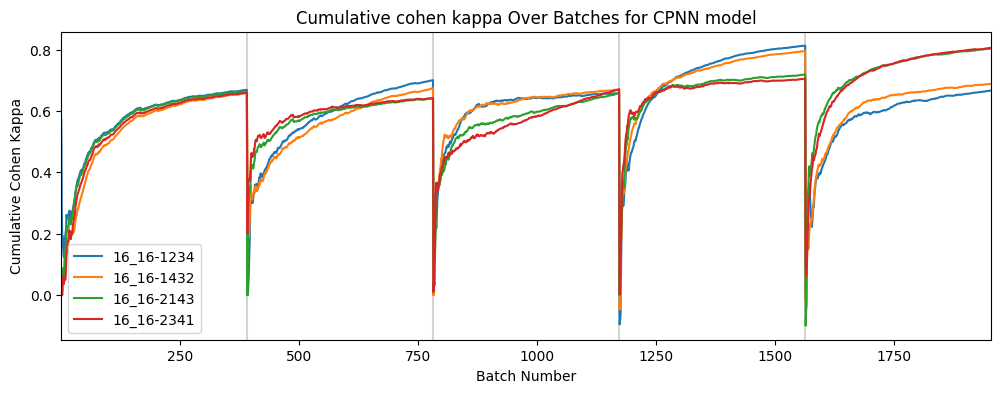

In [ ]:
df1 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-1234.csv'))
df2 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-1432.csv'))
df3 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-2143.csv'))
df4 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-2341.csv'))

def string_to_float(s):
    return float(s.strip('[]'))

# Apply the conversion function to each element in the array
df1 = pd.DataFrame(np.vectorize(string_to_float)(df1))
df2 = pd.DataFrame(np.vectorize(string_to_float)(df2))
df3 = pd.DataFrame(np.vectorize(string_to_float)(df3))
df4 = pd.DataFrame(np.vectorize(string_to_float)(df4))
# Create a DataFrame from the converted data
print( df1.mean(axis=1))
print( df2.mean(axis=1))
print( df3.mean(axis=1))
print( df4.mean(axis=1))

all_x=np.concatenate((df1,df2,df3,df4),axis=0)
y = np.cumsum(all_x, axis=1) / np.arange(1, all_x.shape[1] + 1)
vertical_lines_x = [all_x.shape[1], 2*all_x.shape[1], 3*all_x.shape[1],4*all_x.shape[1]]
x = list(range(1,5*all_x.shape[1] + 1))
fig, ax = plt.subplots(figsize=(12, 4))
ax.margins(x=0.0)
label_list=['16_16-1234','16_16-1432','16_16-2143','16_16-2341']

for i in vertical_lines_x:
  plt.axvline(x=i, color='#D3D3D3', linestyle='-')

for i in range(0,y.shape[0],5):
  ax.plot(x, np.concatenate((y[i],y[i+1],y[i+2],y[i+3],y[i+4]),axis=0), label= label_list[int(i/5)])
plt.xlabel('Batch Number')
plt.ylabel('Cumulative Cohen Kappa')
plt.title('Cumulative cohen kappa Over Batches for CPNN model')
plt.legend()
plt.show()

##Now we also train the pretrain model for each task of the test dataset.

list of accuracies that used for evaluating and selecting the models =  [0.72]
list of kappa values that used for evaluating and selecting the models =  [0.43945096]
index of selcted mask for this task 0
All batches Accuracy=  0.7993046675191816
All batches cohen kappa=  0.5982083318197666
list of accuracies that used for evaluating and selecting the models =  [0.73015625 0.84      ]
list of kappa values that used for evaluating and selecting the models =  [0.46699681 0.66984547]
index of selcted mask for this task 1
All batches Accuracy=  0.8656769501278773
All batches cohen kappa=  0.7294328659772873
list of accuracies that used for evaluating and selecting the models =  [0.78015625 0.8865625  0.87609375]
list of kappa values that used for evaluating and selecting the models =  [0.55729949 0.76786686 0.74810469]
index of selcted mask for this task 1
All batches Accuracy=  0.8562579923273658
All batches cohen kappa=  0.7097696384410267
list of accuracies that used for evaluating and s

All batches Accuracy=  0.8630554667519181
All batches cohen kappa=  0.7218068554149488


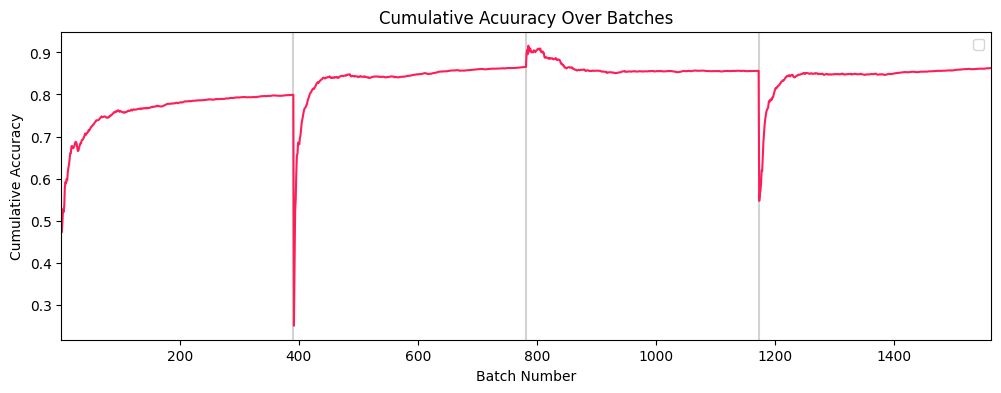

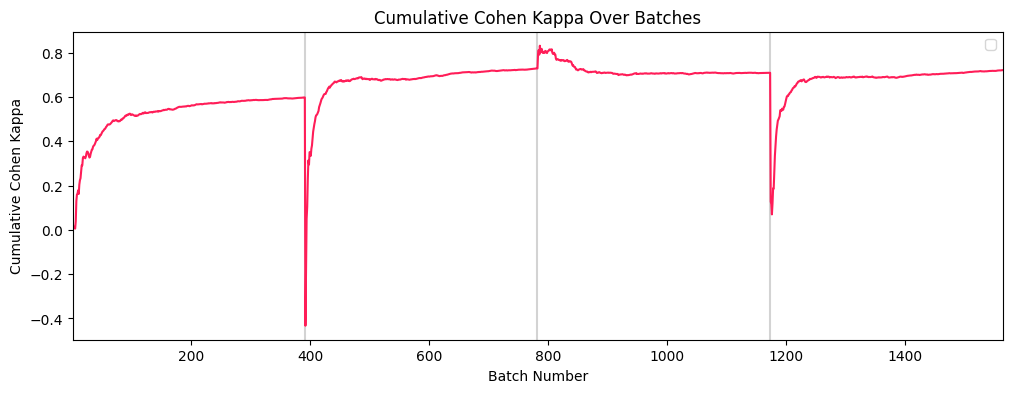

In [ ]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_2341"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_4.pickle'
mask_weights=[]

model=cPB(model_class=PiggyBackGRU, lr = lr , seq_len=seq_len, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init=mask_init, number_of_tasks=number_of_tasks,epoch_size=epoch_size)
iteration=1
# first loop for the iterations, for now it is just 1 iteration.
for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column()
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


In [51]:
# this file is for defining the piggyback layers with mask
import torch
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score
import warnings
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.utils import _pair
from torch.nn.parameter import Parameter
# importing gru math computation block
from torch._VF import gru as _VF_gru
DEFAULT_THRESHOLD = 5e-3
class Binarizer(torch.autograd.Function):
    """Binarizes {0, 1} a real valued tensor."""

    def __init__(self, threshold=DEFAULT_THRESHOLD):

        super(Binarizer, self).__init__()
        Binarizer.threshold = threshold

    def forward(self, inputs):
        outputs = inputs.clone()
        outputs[inputs.le(Binarizer.threshold)] = 0
        outputs[inputs.gt(Binarizer.threshold)] = 1
        #print(outputs)
        return outputs

    def backward(self, gradOutput):
        return gradOutput

class Ternarizer(torch.autograd.Function):
    """Ternarizes {-1, 0, 1} a real valued tensor."""

    def __init__(self, threshold=DEFAULT_THRESHOLD):

        super(Ternarizer, self).__init__()
        Ternarizer.threshold = threshold

    def forward(self, inputs):
        outputs = inputs.clone()
        outputs.fill_(0)
        outputs[inputs < 0] = -1
        outputs[inputs > Ternarizer.threshold] = 1
        return outputs

    def backward(self, gradOutput):
        return gradOutput

def GRUBlockMath(input, hn, weight_thresholded_ih, weight_thresholded_hh, bias_ih_l0,
              bias_hh_l0, batch_size=None, bias=True, num_layers=1, dropout=0.0, training=False, bidirectional= False, batch_first=False):

  #print(weight_thresholded_ih)
  tensors = [weight_thresholded_ih,
             weight_thresholded_hh,
             bias_ih_l0,
             bias_hh_l0]
  #batch_size = torch.tensor(batch_size)
  batch_size= None
  if batch_size==None:
    output, new_hn = _VF_gru(input, hn, tensors, bias, num_layers, dropout, training, bidirectional, batch_first )
  else:
    output, new_hn = _VF_gru(input, batch_size, hn, tensors, bias, num_layers, dropout, training, bidirectional )
  return output, new_hn


class ElementWiseGRU(nn.Module):
    """Modified linear layer."""
    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None,
        bias=True,
        dropout=0.0,
        # this variable should be asked from TA
        training=False,
        bidirectional=False,
        batch_first=False,
        mask_init='uniform',
        mask_scale=1e-2,
        threshold_fn='binarizer',
      	threshold=None,
      	GRU_weights=[],
        seq_len=10,
        GRU_mask_weights=[]
    ):
        super(ElementWiseGRU, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.bias=bias
        self.dropout=dropout
        self.training=training
        self.bidirectional=bidirectional
        self.batch_first=batch_first
        self.mask_init = mask_init
        self.mask_scale = mask_scale
        self.threshold_fn = threshold_fn
        self.threshold=threshold
        self.GRU_weights=GRU_weights
        self.seq_len=seq_len,
        self.GRU_mask_weights=GRU_mask_weights

        # this hn should be defined at the begining and will be updated during the training.
        # I should ask from TA about configuration of hn. if it needed to be updated after each batch or it initialized to zero each iteration
        self.hn = torch.randn((num_layers, seq_len, self.hidden_size))

        if threshold is None:
            threshold = DEFAULT_THRESHOLD
        self.info = {
            'threshold_fn': threshold_fn,
            'threshold': threshold,
        }

        # weight and bias are no longer Parameters.
        self.weight_ih = Variable(torch.Tensor(
            3*hidden_size, input_size), requires_grad=False)
        self.weight_hh = Variable(torch.Tensor(
            3*hidden_size, hidden_size), requires_grad=False)

        self.bias_ih_l0 = Variable(torch.Tensor(
            3*hidden_size), requires_grad=False)
        self.bias_hh_l0 = Variable(torch.Tensor(
            3*hidden_size), requires_grad=False)

        self.weight_ih=GRU_weights[0]
        self.weight_hh=GRU_weights[1]
        self.bias_ih_l0=GRU_weights[2]
        self.bias_hh_l0=GRU_weights[3]
        # Initialize real-valued mask weights.
        self.mask_real_weight_ih = self.weight_ih.data.new(self.weight_ih.size())
        self.mask_real_weight_hh = self.weight_hh.data.new(self.weight_hh.size())
        self.mask_real_bias_ih = self.weight_ih.data.new(self.bias_ih_l0.size())
        self.mask_real_bias_hh = self.weight_hh.data.new(self.bias_hh_l0.size())
        if mask_init == '1s':
            self.mask_real_weight_ih.fill_(mask_scale)
            self.mask_real_weight_hh.fill_(mask_scale)
            self.mask_real_bias_ih.fill_(mask_scale)
            self.mask_real_bias_hh.fill_(mask_scale)
        elif mask_init == 'uniform':
            self.mask_real_weight_ih.uniform_(-1 * mask_scale, mask_scale)
            self.mask_real_weight_hh.uniform_(-1 * mask_scale, mask_scale)
            self.mask_real_bias_ih.uniform_(-1 * mask_scale, mask_scale)
            self.mask_real_bias_hh.uniform_(-1 * mask_scale, mask_scale)
        if GRU_mask_weights!=[]:
            self.mask_real_weight_ih = Parameter(self.GRU_mask_weights[0])
            self.mask_real_weight_hh = Parameter(self.GRU_mask_weights[1])
            self.mask_real_bias_ih = Parameter(self.GRU_mask_weights[2])
            self.mask_real_bias_hh = Parameter(self.GRU_mask_weights[3])

        else:
            self.mask_real_weight_ih = Parameter(self.mask_real_weight_ih)
            self.mask_real_weight_hh = Parameter(self.mask_real_weight_hh)
            self.mask_real_bias_ih = Parameter(self.mask_real_bias_ih)
            self.mask_real_bias_hh = Parameter(self.mask_real_bias_hh)


        if threshold_fn == 'binarizer':
            self.threshold_fn = Binarizer(threshold=threshold)
        elif threshold_fn == 'ternarizer':
            self.threshold_fn = Ternarizer(threshold=threshold)

    def forward(self,input):
        if torch.isnan(self.mask_real_weight_ih).any():
            print('NaN exists ............................................')
            #print(self.mask_real_weight_ih)
            if self.mask_init == 'uniform':
                self.mask_real_weight_ih.uniform_(-1 * self.mask_scale, self.mask_scale)
                self.mask_real_weight_hh.uniform_(-1 * self.mask_scale, self.mask_scale)
            self.mask_real_weight_ih = Parameter(self.mask_real_weight_ih)
            self.mask_real_weight_hh = Parameter(self.mask_real_weight_hh)

        # Get binarized/ternarized mask from real-valued mask.

        mask_thresholded_ih = self.threshold_fn.apply(self.mask_real_weight_ih)
        mask_thresholded_hh = self.threshold_fn.apply(self.mask_real_weight_hh)
        mask_thresholded_bias_ih = self.threshold_fn.apply(self.mask_real_bias_ih)
        mask_thresholded_bias_hh = self.threshold_fn.apply(self.mask_real_bias_hh)

        # Mask weights with above mask.
        weight_thresholded_ih = mask_thresholded_ih * self.weight_ih
        weight_thresholded_hh = mask_thresholded_hh * self.weight_hh
        weight_thresholded_bias_ih = mask_thresholded_bias_ih * self.bias_ih_l0
        weight_thresholded_bias_hh = mask_thresholded_bias_hh * self.bias_hh_l0

        out,self.hn = GRUBlockMath(input, self.hn, weight_thresholded_ih, weight_thresholded_hh,
                                weight_thresholded_bias_ih, weight_thresholded_bias_hh, self.batch_size, self.bias, self.num_layers, self.dropout,
                                self.training, self.bidirectional, self.batch_first)
        # Get output using modified weight.

        return out
    def _apply(self, fn):
        for module in self.children():
            module._apply(fn)

        for param in self._parameters.values():
            if param is not None:
                # Variables stored in modules are graph leaves, and we don't
                # want to create copy nodes, so we have to unpack the data.
                param.data = fn(param.data)
                if param._grad is not None:
                    param._grad.data = fn(param._grad.data)

        for key, buf in self._buffers.items():
            if buf is not None:
                self._buffers[key] = fn(buf)

        self.weight_ih.data = fn(self.weight_ih.data)
        self.weight_hh.data = fn(self.weight_hh.data)
        self.bias_ih_l0.data = fn(self.bias_ih_l0.data)
        self.bias_hh_l0.data = fn(self.bias_ih_l0.data)
        #if self.bias is not None and self.bias_ih_l0.data is not None:
        #    self.bias_ih_l0.data = fn(self.bias_ih_l0.data)
        #if self.bias is not None and self.bias_hh_l0.data is not None:
        #    self.bias_hh_l0.data = fn(self.bias_hh_l0.data)


class ElementWiseLinear(nn.Module):
    """Modified linear layer."""

    def __init__(
        self,
        in_features,
        out_features,
        bias=True,
        mask_init='uniform',
        mask_scale=1e-2,
        threshold_fn='binarizer',
        threshold=None,
        linear_weights=[],
        Linear_mask_weights=[]
        ):
        super(ElementWiseLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.threshold_fn = threshold_fn
        self.mask_scale = mask_scale
        self.mask_init = mask_init
        self.linear_weights=linear_weights
        self.Linear_mask_weights=Linear_mask_weights
        if threshold is None:
            threshold = DEFAULT_THRESHOLD
        self.info = {
            'threshold_fn': threshold_fn,
            'threshold': threshold,
        }

        # weight and bias are no longer Parameters.
        self.weight = Variable(torch.Tensor(
            out_features, in_features), requires_grad=False)
        if bias:
            self.bias = Variable(torch.Tensor(
                out_features), requires_grad=False)
        else:
            self.register_parameter('bias', None)
        self.weight=linear_weights[0]
        self.bias=linear_weights[1]
        # Initialize real-valued mask weights.
        self.mask_real_linear = self.weight.data.new(self.weight.size())
        if mask_init == '1s':
            self.mask_real_linear.fill_(mask_scale)
        elif mask_init == 'uniform':
            self.mask_real_linear.uniform_(-1 * mask_scale, mask_scale)
        # mask_real_linear is now a trainable parameter.
        if Linear_mask_weights!=[]:
            self.mask_real_linear = Parameter(self.Linear_mask_weights)
        else:
            self.mask_real_linear = Parameter(self.mask_real_linear)
        # Initialize the thresholder.
        if threshold_fn == 'binarizer':
            self.threshold_fn = Binarizer(threshold=threshold)
        elif threshold_fn == 'ternarizer':
            self.threshold_fn = Ternarizer(threshold=threshold)

    def forward(self, input):
        # Get binarized/ternarized mask from real-valued mask.
        mask_thresholded = self.threshold_fn.apply(self.mask_real_linear)
        # Mask weights with above mask.
        weight_thresholded = mask_thresholded * self.weight
        # Get output using modified weight.
        return F.linear(input, weight_thresholded, self.bias)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_features=' + str(self.in_features) \
            + ', out_features=' + str(self.out_features) + ')'

    def _apply(self, fn):
        for module in self.children():
            module._apply(fn)

        for param in self._parameters.values():
            if param is not None:
                # Variables stored in modules are graph leaves, and we don't
                # want to create copy nodes, so we have to unpack the data.
                param.data = fn(param.data)
                if param._grad is not None:
                    param._grad.data = fn(param._grad.data)

        for key, buf in self._buffers.items():
            if buf is not None:
                self._buffers[key] = fn(buf)

        self.weight.data = fn(self.weight.data)
        self.bias.data = fn(self.bias.data)

In [52]:
# this file is for Main network that contains piggyback layers with masks.
# here we just
import torch
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score
import warnings
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.utils import _pair
from torch.nn.parameter import Parameter
#import models.piggyback_layers as nl


class PiggyBackGRU(nn.Module):
    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None,
        bias=True,
        dropout=0.0,
        # this variable should be asked from TA
        training=False,
        bidirectional=False,
        batch_first=False,
        mask_init='uniform',
      	mask_scale=1e-2,
        threshold_fn='binarizer',
      	threshold=None,
      	all_weights=[],
        seq_len=10,
        mask_weights=[]
        ):
        super(PiggyBackGRU, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.threshold_fn = threshold_fn
        self.mask_scale = mask_scale
        self.mask_init = mask_init
        self.all_weights=all_weights
        self.seq_len=seq_len
        self.mask_weights=mask_weights

        self.gru_weight_ih_l0=all_weights['gru.weight_ih_l0']
        self.gru_weight_hh_l0=all_weights['gru.weight_hh_l0']
        self.gru_bias_ih_l0=all_weights['gru.bias_ih_l0']
        self.gru_bias_hh_l0=all_weights['gru.bias_hh_l0']
        self.linear_weight=all_weights['linear.weight']
        self.linear_bias=all_weights['linear.bias']
        self.GRU_weights=[self.gru_weight_ih_l0,
           		   self.gru_weight_hh_l0,
           		   self.gru_bias_ih_l0,
           		   self.gru_bias_hh_l0]

        self.linear_weights=[
          			self.linear_weight,
          			self.linear_bias]
        if mask_weights!=[]:
            self.GRU_mask_weights=mask_weights[0:4]
            self.Linear_mask_weights=mask_weights[-1]
        else:
            self.GRU_mask_weights=[]
            self.Linear_mask_weights=[]
        # define nn network here

        self.classifier = nn.Sequential(
            ElementWiseGRU(input_size=input_size, device=device, num_layers=num_layers, hidden_size=hidden_size, bias=bias, dropout=dropout,
                bidirectional=bidirectional, training=training, mask_init=mask_init,
                mask_scale=mask_scale, threshold_fn=threshold_fn, threshold=threshold,
                GRU_weights=self.GRU_weights, seq_len=self.seq_len, GRU_mask_weights=self.GRU_mask_weights),

            ElementWiseLinear(in_features=hidden_size, out_features=output_size,
                mask_init=mask_init, mask_scale=mask_scale, threshold_fn=threshold_fn,
				threshold=threshold, linear_weights=self.linear_weights, Linear_mask_weights=self.Linear_mask_weights)
        )


    def forward(self,input):
        out = self.classifier(input)
        return out

In [53]:
# first we need to load the pretrain model and then transfer the weights to the our impelemnted network.
import torch
import numpy as np
import warnings
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.utils import _pair
from torch.nn.parameter import Parameter
#from models.pretrain import *
#from models.PiggyBackGRU import *
import pickle
class ModifiedGRU(nn.Module):
    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None,
        bias=True,
        dropout=0.0,
        # this variable should be asked from TA
        training=False,
        bidirectional=False,
        batch_first=False,
        mask_init='unifrom',
      	mask_scale=1e-2,
        threshold_fn='binarizer',
      	threshold=None,
      	pretrain_model_addr='',
        seq_len=10,
        mask_weights=[]
    ):
        super(ModifiedGRU, self).__init__()


        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.threshold_fn = threshold_fn
        self.mask_scale = mask_scale
        self.mask_init = mask_init
        self.pretrain_model_addr=pretrain_model_addr
        self.seq_len=seq_len
        self.mask_weights=mask_weights
        self.pretrain_model = PretrainModel(
        input_size=input_size,
        device=torch.device("cpu"),
      	num_layers=num_layers,
        hidden_size=hidden_size,
        output_size=output_size,
        batch_size=batch_size,
          )

        with open(self.pretrain_model_addr, "rb") as fp:
    		    self.pretrain_model.load_state_dict(pickle.load(fp),strict=False)
        self.all_weights=self.pretrain_model.state_dict()
        self.classifier=PiggyBackGRU(input_size=input_size, device=device,
                               num_layers=num_layers, hidden_size=hidden_size,
                               output_size=output_size, batch_size=batch_size,
                               many_to_one=many_to_one,remember_states=remember_states,
                               bias=bias, training=training, dropout=dropout,
                               bidirectional=bidirectional, batch_first=batch_first,
                               mask_init=mask_init, mask_scale=mask_scale,
                               threshold_fn=threshold_fn, threshold=threshold,
                               all_weights=self.all_weights,seq_len=seq_len, mask_weights=mask_weights
                               )

    def forward(self,input):
        out = self.classifier(input)
        return out

In [54]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_1432"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_1.pickle'
mask_weights=[]

model=cPB(model_class=PiggyBackGRU, lr = lr , seq_len=seq_len, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init=mask_init, number_of_tasks=number_of_tasks,epoch_size=epoch_size)
iteration=1
# first loop for the iterations, for now it is just 1 iteration.
for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column()
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


list of accuracies that used for evaluating and selecting the models =  [0.67375]
list of kappa values that used for evaluating and selecting the models =  [0.37167135]
index of selcted mask for this task 0
All batches Accuracy=  0.8332800511508951
All batches cohen kappa=  0.6684910060184034
list of accuracies that used for evaluating and selecting the models =  [0.694375   0.79953125]
list of kappa values that used for evaluating and selecting the models =  [0.38229598 0.58693977]
index of selcted mask for this task 1
All batches Accuracy=  0.8270460358056266
All batches cohen kappa=  0.6509416357464041


KeyboardInterrupt: ignored

In [8]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score
import warnings

from models.cpnn_columns import cPNNColumns
from models.utils import (
    customized_loss,
    accuracy,
    cohen_kappa,
    kappa_temporal,
    get_samples_outputs,
    get_pred_from_outputs, kappa_temporal_score,
)
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
import copy
#from models.PiggyBackGRU import(
#	PiggyBackGRU,
#)
from PiggyBackGRU import(
	PiggyBackGRU,
)
#from models.network import ModifiedGRU
from network import ModifiedGRU
import matplotlib.pyplot as plt
class cPB:
    """
    Class that implements all the cPNN structure.
    """

    def __init__(
        self,
        model_class=PiggyBackGRU,
        device=None,
        stride: int = 1,
        lr: float = 0.01,
        seq_len: int = 5,
        pretrain_model_addr='',
        mask_weights=[],
        mask_init='1s',
        number_of_tasks=4,
        epoch_size=5,
        **kwargs,
    ):

      self.loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
      self.stride=stride
      self.seq_len=seq_len
      self.lr=lr
      self.pretrain_model_addr=pretrain_model_addr
      self.mask_init=mask_init
      self.weights_list=[]
      self.selected_mask_index=[]
      self.epoch_size=epoch_size
      self.all_batch_acc=[[] for _ in range(number_of_tasks)]
      self.all_batch_kappa=[[] for _ in range(number_of_tasks)]
      self.acc_saving = [[]]
      self.cohen_kappa_saving=[[]]

      if model_class==PiggyBackGRU and pretrain_model_addr!='':
        self.model = ModifiedGRU(pretrain_model_addr=pretrain_model_addr,seq_len=seq_len,mask_weights=mask_weights,mask_init=mask_init)
        self.initial_weights = self.model.state_dict()

      self.final_weights=[]

    def get_seq_len(self):
        return self.seq_len

    def _cut_in_sequences(self, x, y):
        seqs_features = []
        seqs_targets = []
        for i in range(0, len(x), self.stride):
            if len(x) - i >= self.seq_len:
                seqs_features.append(x[i : i + self.seq_len, :].astype(np.float32))
                if y is not None:
                    seqs_targets.append(
                        np.asarray(y[i : i + self.seq_len], dtype=np.int_)
                    )
        return np.asarray(seqs_features), np.asarray(seqs_targets)

    def _cut_in_sequences_tensors(self, x, y):
        seqs_features = []
        seqs_targets = []
        for i in range(0, x.size()[0], self.stride):
            if x.size()[0] - i >= self.seq_len:
                seqs_features.append(
                    x[i : i + self.seq_len, :].view(1, self.seq_len, x.size()[1])
                )
                seqs_targets.append(y[i : i + self.seq_len].view(1, self.seq_len))
        seq_features = torch.cat(seqs_features, dim=0)
        seqs_targets = torch.cat(seqs_targets, dim=0)
        return seq_features, seqs_targets

    def _convert_to_tensor_dataset(self, x, y=None):

        x, y = self._cut_in_sequences(x, y)
        x = torch.tensor(x)
        if len(y) > 0:
            y = torch.tensor(y).type(torch.LongTensor)
            return data_utils.TensorDataset(x, y)
        return x

    def _load_batch(self, x: np.array, y: np.array = None):

        batch = self._convert_to_tensor_dataset(x, y)
        batch_loader = DataLoader(
            batch, batch_size=batch.tensors[0].size()[0], drop_last=False
        )
        y_seq = None
        for x, y_seq in batch_loader:  # only to take x and y from loader
            break
        y = torch.tensor(y)
        return x, y, y_seq


    def learn_many(self,x,y,task_number):

      self.model=self.rebuild_model(task_number)

      x = np.array(x)
      y = list(y)

      optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
      x, y, _ = self._load_batch(x, y)
      for i in range(0,self.epoch_size):
        y_pred = self.model(x)
        y_pred = get_samples_outputs(y_pred)
        pred, _ = get_pred_from_outputs(y_pred)
        loss = self.loss_fn(y_pred, y)
        # backward pass
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        # update weights
        optimizer.step()
      self.update_weights(task_number)

    def mask_return(self):
      return self.model.state_dict()
    def update_weights(self,task_number):
      self.weights_list[task_number]=copy.deepcopy(self.model.state_dict())

    def rebuild_model(self,task_number):
      param_list=[]
      for params in self.weights_list[task_number]:
        param_list.append(params)

      mask_weights=[]
      mask_weights.append(self.weights_list[task_number][param_list[-5]])
      mask_weights.append(self.weights_list[task_number][param_list[-4]])
      mask_weights.append(self.weights_list[task_number][param_list[-3]])
      mask_weights.append(self.weights_list[task_number][param_list[-2]])
      mask_weights.append(self.weights_list[task_number][param_list[-1]])
      self.model=ModifiedGRU(pretrain_model_addr=self.pretrain_model_addr,
                             seq_len=self.seq_len,mask_weights=mask_weights,
                             mask_init=self.mask_init)
      return self.model

    def final_weights_saving(self):
      self.final_weights.append(copy.deepcopy(self.model.state_dict()))

    def predict_many(self,x,y,task_number):
      x = np.array(x)
      y = list(y)
      x, y, _ = self._load_batch(x, y)
      y_pred = self.model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      kappa=cohen_kappa(y,pred).item()
      acc=accuracy_score(np.array(y),np.array(pred))
      self.acc_saving[task_number].append(acc)
      self.cohen_kappa_saving[task_number].append(kappa)
      #return acc, kappa

    def initial_weights_returning(self):
      return self.initial_weights

    def weights_copy(self, task_number):
      weights_list=[]
      for i in range(0,task_number-1):
        self.weights_list.append(copy.deepcopy(self.final_weights[i]))
      self.weights_list.append(copy.deepcopy(self.initial_weights))

    def add_new_column(self):
      avg_acc= np.mean(self.acc_saving, axis=1)
      avg_cohen_kappa = np.mean(self.cohen_kappa_saving, axis=1)
      index_of_best_acc = np.argmax(avg_acc)
      self.selected_mask_index.append(index_of_best_acc)
      print('list of accuracies that used for evaluating and selecting the models = ',avg_acc)
      print('list of kappa values that used for evaluating and selecting the models = ',avg_cohen_kappa)
      print('index of selcted mask for this task',index_of_best_acc)
      return index_of_best_acc
    def save_final_metrics(self,task,best_mask_index):
      self.all_batch_acc[task-1]=copy.deepcopy(self.acc_saving[best_mask_index])
      self.all_batch_kappa[task-1]=copy.deepcopy(self.cohen_kappa_saving[best_mask_index])
      print('All batches Accuracy= ', np.mean(self.all_batch_acc[task-1]))
      print('All batches cohen kappa= ', np.mean(self.all_batch_kappa[task-1]))
      self.acc_saving = [[] for _ in range(task+1)]
      self.cohen_kappa_saving=[[] for _ in range(task+1)]

    def plotting(self):

      x0=np.cumsum(self.all_batch_acc[0]) / np.arange(1, len(self.all_batch_acc[0]) + 1)
      x1=np.cumsum(self.all_batch_acc[1]) / np.arange(1, len(self.all_batch_acc[1]) + 1)
      x2=np.cumsum(self.all_batch_acc[2]) / np.arange(1, len(self.all_batch_acc[2]) + 1)
      x3=np.cumsum(self.all_batch_acc[3]) / np.arange(1, len(self.all_batch_acc[3]) + 1)
      all_x=np.concatenate((x0,x1,x2,x3),axis=0)
      vertical_lines_x = [len(x0), len(x0)+len(x1), len(x0)+len(x1)+len(x2)]
      y = all_x
      x = list(range(1,len(all_x) + 1))
      fig, ax = plt.subplots(figsize=(12, 4))
      ax.margins(x=0.0)
      for i in vertical_lines_x:
          plt.axvline(x=i, color='#D3D3D3', linestyle='-')
      ax.plot(x, y, color='#ff1d58')
      plt.xlabel('Batch Number')
      plt.ylabel('Cumulative Accuracy')
      plt.title('Cumulative Acuuracy Over Batches')
      plt.legend()
      plt.show()

      x0=np.cumsum(self.all_batch_kappa[0]) / np.arange(1, len(self.all_batch_kappa[0]) + 1)
      x1=np.cumsum(self.all_batch_kappa[1]) / np.arange(1, len(self.all_batch_kappa[1]) + 1)
      x2=np.cumsum(self.all_batch_kappa[2]) / np.arange(1, len(self.all_batch_kappa[2]) + 1)
      x3=np.cumsum(self.all_batch_kappa[3]) / np.arange(1, len(self.all_batch_kappa[3]) + 1)
      all_x=np.concatenate((x0,x1,x2,x3),axis=0)
      y = all_x
      fig, ax = plt.subplots(figsize=(12, 4))
      ax.margins(x=0.0)
      for i in vertical_lines_x:
          plt.axvline(x=i, color='#D3D3D3', linestyle='-')
      ax.plot(x, y, color='#ff1d58')
      plt.xlabel('Batch Number')
      plt.ylabel('Cumulative Cohen Kappa')
      plt.title('Cumulative Cohen Kappa Over Batches')
      plt.legend()
      plt.show()

In [ ]:
pd.DataFrame(model.all_batch_acc).to_csv('results/acc-CPB-16_16-1432-t1.csv', index=False)
pd.DataFrame(model.all_batch_kappa).to_csv('results/kappa-CPB-16_16-1432-t1.csv', index=False)

In [ ]:
df1 = np.array(pd.read_csv('results/kappa-16_16-1234-4.csv'))
df2 = np.array(pd.read_csv('results/kappa-16_16-1432-4.csv'))
df3 = np.array(pd.read_csv('results/kappa-16_16-2143-4.csv'))
df4 = np.array(pd.read_csv('results/kappa-16_16-2341-4.csv'))
all_x=np.concatenate((df1,df2,df3,df4),axis=0)
y = np.cumsum(all_x, axis=1) / np.arange(1, all_x.shape[1] + 1)
vertical_lines_x = [all_x.shape[1], 2*all_x.shape[1], 3*all_x.shape[1]]
x = list(range(1,4*all_x.shape[1] + 1))
fig, ax = plt.subplots(figsize=(12, 4))
ax.margins(x=0.0)
label_list=['16_16-1234','16_16-1432','16_16-2143','16_16-2341']

for i in vertical_lines_x:
  plt.axvline(x=i, color='#D3D3D3', linestyle='-')

for i in range(0,y.shape[0],4):
  ax.plot(x, np.concatenate((y[i],y[i+1],y[i+2],y[i+3]),axis=0), label= label_list[int(i/4)])
plt.xlabel('Batch Number')
plt.ylabel('Cumulative Cohen Kappa')
plt.title('Cumulative Cohen Kappa Over Batches')
plt.legend()
plt.show()